# Example 4: Mean Risk Optimisation with Factor Models with Linear Factor Constraints

## 1. Download data.

In [1]:
using PortfolioOptimiser, TimeSeries, DataFrames, PrettyTables, Clarabel, HiGHS, YFinance,
      GraphRecipes, StatsPlots, JuMP, GLM

# Format for pretty tables.
fmt1 = (v, i, j) -> begin
    if j == 1
        return Date(v)
    else
        return v
    end
end;
fmt2 = (v, i, j) -> begin
    if j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v, digits=5))" : v
    end
end;
fmt3 = (v, i, j) -> begin
    if j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=4)) %" : v
    end
end;

# Convert prices to time array.
function stock_price_to_time_array(x)
    # Only get the keys that are not ticker or datetime.
    coln = collect(keys(x))[3:end]
    # Convert the dictionary into a matrix.
    m = hcat([x[k] for k ∈ coln]...)
    return TimeArray(x["timestamp"], m, Symbol.(coln), x["ticker"])
end

# Asset tickers.
assets = sort!(["AAPL", "ADI", "ADP", "AMGN", "AMZN", "BKNG", "CMCSA", "COST", "CSCO",
                "GILD", "GOOG", "GOOGL", "HON", "ISRG", "LIN", "MAR", "META", "MRK", "MSFT",
                "NFLX", "NVDA", "ORLY", "PANW", "QCOM", "SBUX", "T", "TMUS", "TSLA", "TXN",
                "VRTX"])
# Factor tickers.
factors = sort!(["MTUM", "QUAL", "SIZE", "USMV", "VLUE", "LRGF", "INTF", "GLOF", "EFAV",
                 "EEMV"])

tickers = [assets; factors]

# Prices date range.
Date_0 = "2019-01-01"
Date_1 = "2025-01-31"

# Download the price data using YFinance.
prices = get_prices.(tickers; startdt = Date_0, enddt = Date_1)
prices = stock_price_to_time_array.(prices)
prices = hcat(prices...)
cidx = colnames(prices)[occursin.(r"adj", string.(colnames(prices)))]
prices = prices[cidx]
TimeSeries.rename!(prices, Symbol.(tickers))
pretty_table(prices[1:5]; formatters = fmt1)

┌────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│  timestamp │    AAPL │     ADI │     ADP │    AMGN │    AMZN │    BKNG │   CMCSA │    COST │    CSCO │    GILD │    GOOG │   GOOGL │     HON │    ISRG │     LIN │     MAR │    META │     MRK │    MSFT │    NFLX │    NVDA │    ORLY │    PANW │    QCOM │    SBUX │       T │    TMUS │    TSLA │     TXN │    VRTX │    EEMV │    EFAV │    GLOF │    INTF │    LRGF │    MTUM │    QUAL │    SIZE │    USMV │    VLUE │
│   DateTime │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float

## 2. Estimating Mean Risk Portfolios

### 2.1. Factor and asset statistics

In order to use factor models, we need to estimate how the factors and assets are related. The relationships are summarised by the loadings matrix, which is obtained via regression. For this basic tutorial we will use the defaults.

This is a simple example so we will only use default parameters for computing the statistics.

`PortfolioOptimiser.MeanEstimator`, `PortfolioOptimiser.PortfolioOptimiserCovCor`, `FactorType`, `asset_statistics!`, `factor_statistics!`.

In [2]:
# Creating the portfolio object. Internally computes the returns if you give a prices TimeArray.
port = Portfolio(; prices = prices[Symbol.(assets)], f_prices = prices[Symbol.(factors)],
                 # Continuous solvers.
                 solvers = PortOptSolver(; name = :Clarabel, solver = Clarabel.Optimizer,
                                         params = Dict("verbose" => false)),
                 # Discrete solvers (for discrete allocation).
                 alloc_solvers = PortOptSolver(; name = :HiGHS,
                                               solver = optimizer_with_attributes(HiGHS.Optimizer,
                                                                                  MOI.Silent() => true)))
# Compute relevant statistics.
# Expected returns, covariance estimation and factor estimation methods.
mu_type = MuSimple()
cov_type = PortCovCor()
factor_type = FactorType()

asset_statistics!(port; mu_type = mu_type, cov_type = cov_type, set_kurt = false,
                  set_skurt = false, set_skew = false, set_sskew = false)
factor_statistics!(port; factor_type = factor_type, cov_type = cov_type, mu_type = mu_type)

# Show the loadings matrix.
pretty_table(port.loadings; formatters = fmt2)

┌─────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ tickers │    const │     EEMV │     EFAV │     GLOF │     INTF │     LRGF │     MTUM │     QUAL │     SIZE │     USMV │     VLUE │
│  String │  Float64 │  Float64 │  Float64 │  Float64 │  Float64 │  Float64 │  Float64 │  Float64 │  Float64 │  Float64 │  Float64 │
├─────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│    AAPL │  0.00047 │   0.3745 │      0.0 │ -0.51584 │      0.0 │  1.70424 │      0.0 │  1.08206 │ -0.78701 │ -0.21274 │ -0.42671 │
│     ADI │   8.0e-5 │      0.0 │  -0.2065 │    0.877 │      0.0 │      0.0 │  0.13771 │  0.56252 │  0.56364 │ -0.85734 │      0.0 │
│     ADP │  0.00012 │      0.0 │      0.0 │      0.0 │ -0.15139 │ -0.27028 │ -0.10547 │  0.29239 │  0.39497 │  1.02401 │      0.0 │
│    AMGN │  0.00016 │      0.0 │  0.41865 │      0.0 │ -0.31138 │   

### 2.2. Optimise Portfolios

In [3]:
# Creating the optimisation object.
rm = SD() # Risk measure.
obj = Sharpe() # Objective function. Can be `MinRisk()`, `Utility()`, `Sharpe()`, `MaxRet()`.
class = FM()
# `Trad` optimisation corresponds to the classic mean risk optimisation.
type = Trad(; rm = rm, obj = obj, class = class)
# Classic portfolio.
w1 = optimise!(port, type)
# Factor model portfolio.
pretty_table(w1; formatters = fmt3)

┌─────────┬───────────┐
│ tickers │   weights │
│  String │   Float64 │
├─────────┼───────────┤
│    AAPL │     0.0 % │
│     ADI │     0.0 % │
│     ADP │     0.0 % │
│    AMGN │     0.0 % │
│    AMZN │     0.0 % │
│    BKNG │     0.0 % │
│   CMCSA │     0.0 % │
│    COST │ 34.8736 % │
│    CSCO │     0.0 % │
│    GILD │  6.1333 % │
│    GOOG │     0.0 % │
│   GOOGL │     0.0 % │
│     HON │     0.0 % │
│    ISRG │     0.0 % │
│     LIN │     0.0 % │
│     MAR │     0.0 % │
│    META │     0.0 % │
│     MRK │     0.0 % │
│    MSFT │     0.0 % │
│    NFLX │     0.0 % │
│    NVDA │ 17.6818 % │
│    ORLY │ 13.8435 % │
│    PANW │  5.5076 % │
│    QCOM │     0.0 % │
│    SBUX │     0.0 % │
│       T │     0.0 % │
│    TMUS │ 12.7357 % │
│    TSLA │  9.2244 % │
│     TXN │     0.0 % │
│    VRTX │     0.0 % │
└─────────┴───────────┘


## 3. Factor constraints

### 3.1. Creating the constraints

The function `factor_constraints` takes in two dataframes, one defining the constraints, and the loadings matrix and turns them into a matrix and vector which sets the constraints as $\\mathbf{A} \\bm{x} >= \\bm{b}$.

First lets check out the loadings matrix in order to create feasable constraints.

In [4]:
pretty_table(describe(port.loadings); formatters = fmt3)

┌──────────┬─────────────────────┬─────────────┬─────────────────────┬────────────┬──────────┬──────────┐
│ variable │                mean │         min │              median │        max │ nmissing │   eltype │
│   Symbol │ U{Nothing, Float64} │         Any │ U{Nothing, Float64} │        Any │    Int64 │ DataType │
├──────────┼─────────────────────┼─────────────┼─────────────────────┼────────────┼──────────┼──────────┤
│  tickers │             nothing │        AAPL │             nothing │       VRTX │    0.0 % │   String │
│    const │            0.0313 % │    -0.023 % │            0.0272 % │   0.1632 % │    0.0 % │  Float64 │
│     EEMV │            3.2376 % │  -16.2833 % │               0.0 % │  37.4503 % │    0.0 % │  Float64 │
│     EFAV │           -2.7777 % │ -106.8645 % │               0.0 % │  41.8648 % │    0.0 % │  Float64 │
│     GLOF │            6.3326 % │  -52.8037 % │               0.0 % │ 107.2898 % │    0.0 % │  Float64 │
│     INTF │            1.8833 % │  -39.3667 %

Constrain factors.

In [5]:
constraints = DataFrame(; Enabled = [true, true, true, true],
                        Factor = ["SIZE", "QUAL", "USMV", "MTUM"],
                        Sign = [">=", ">=", "<=", ">="], Value = [0.2, 0.6, -0.7, 0.45],
                        Relative_Factor = ["", "LRGF", "", ""])
pretty_table(constraints)

┌─────────┬────────┬────────┬─────────┬─────────────────┐
│ Enabled │ Factor │   Sign │   Value │ Relative_Factor │
│    Bool │ String │ String │ Float64 │          String │
├─────────┼────────┼────────┼─────────┼─────────────────┤
│    true │   SIZE │     >= │     0.2 │                 │
│    true │   QUAL │     >= │     0.6 │            LRGF │
│    true │   USMV │     <= │    -0.7 │                 │
│    true │   MTUM │     >= │    0.45 │                 │
└─────────┴────────┴────────┴─────────┴─────────────────┘


Create linear constraint matrix and vector and optimise with these constraints.

In [6]:
A1, B1 = factor_constraints(constraints, port.loadings)

# Clear the arrays because the code asserts the dimensions.
port.a_ineq = Matrix(undef, 0, 0)
port.b_ineq = Vector(undef, 0)
port.a_ineq = A1
port.b_ineq = B1

w2 = optimise!(port, type)
pretty_table(w2; formatters = fmt3)

┌─────────┬───────────┐
│ tickers │   weights │
│  String │   Float64 │
├─────────┼───────────┤
│    AAPL │ 24.9594 % │
│     ADI │     0.0 % │
│     ADP │     0.0 % │
│    AMGN │     0.0 % │
│    AMZN │     0.0 % │
│    BKNG │     0.0 % │
│   CMCSA │     0.0 % │
│    COST │ 19.9748 % │
│    CSCO │     0.0 % │
│    GILD │     0.0 % │
│    GOOG │     0.0 % │
│   GOOGL │     0.0 % │
│     HON │     0.0 % │
│    ISRG │     0.0 % │
│     LIN │     0.0 % │
│     MAR │     0.0 % │
│    META │     0.0 % │
│     MRK │     0.0 % │
│    MSFT │     0.0 % │
│    NFLX │     0.0 % │
│    NVDA │  3.7277 % │
│    ORLY │     0.0 % │
│    PANW │  7.7241 % │
│    QCOM │     0.0 % │
│    SBUX │     0.0 % │
│       T │     0.0 % │
│    TMUS │ 10.6198 % │
│    TSLA │ 32.9941 % │
│     TXN │     0.0 % │
│    VRTX │     0.0 % │
└─────────┴───────────┘


In order to verify that the constraints have been held, we can perform a regression.

In [7]:
# Add constant term.
X = [ones(size(port.fm_returns, 1)) port.f_returns]
# Portfolio returns according to the factor model.
y = port.fm_returns * w2.weights
# Generalised linear model linking the portfolio returns to the factors in X.
res = GLM.lm(X, y)
# Generate dataframe with the factors and their regression coefficients.
df = DataFrame(; :factors => ["const"; factors], :coefs => coef(res))
pretty_table(df; formatters = fmt3)

┌─────────┬────────────┐
│ factors │      coefs │
│  String │    Float64 │
├─────────┼────────────┤
│   const │   0.0922 % │
│    EEMV │   6.0948 % │
│    EFAV │      0.0 % │
│    GLOF │ -10.9238 % │
│    INTF │  -1.8353 % │
│    LRGF │ 110.6854 % │
│    MTUM │     45.0 % │
│    QUAL │  50.6854 % │
│    SIZE │  39.5273 % │
│    USMV │ -75.9064 % │
│    VLUE │ -66.4477 % │
└─────────┴────────────┘


We can see that the constraints hold.

| Factor |     Constraint     |              Value               |
|-------:|:------------------:|:---------------------------------|
|  SIZE  |    SIZE >= 0.2     |         0.395261 >= 0.2          |
|  QUAL  | LRGF - QUAL >= 0.6 | 1.106847 - 0.506847 = 0.6 >= 0.6 |
|  USMV  |    USMV <= -0.7    |         -0.75905 <= -0.7         |
|  MTUM  |    MTUM >= 0.45    |           0.45 >= 0.45           |

### 3.2. Efficient Frontier

We can plot the efficient frontier for the factor model. Which will look different factor model one because the constraints will have to be satisfied at every point.

In [8]:
points = 50
frontier = efficient_frontier!(port, type; points = points)
pretty_table(frontier[:weights]; formatters = fmt3)

┌─────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ tickers │         1 │         2 │         3 │         4 │         5 │         6 │         7 │         8 │         9 │        10 │        11 │        12 │        13 │        14 │        15 │        16 │        17 │        18 │        19 │        20 │        21 │        22 │        23 │        24 │        25 │        26 │        27 │        28 │        29 │        30 │     

Plot frontier.

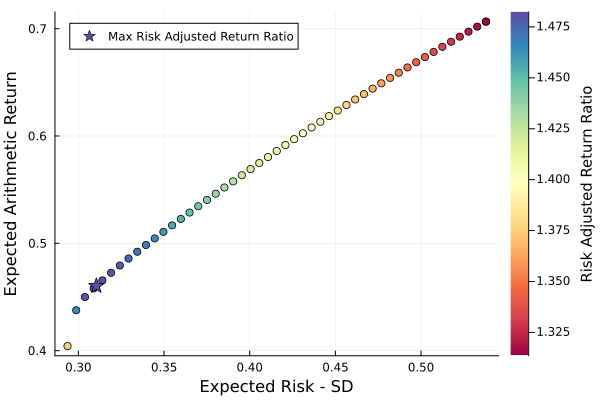

In [9]:
plot_frontier(port; rm = rm)

Plot frontier area.

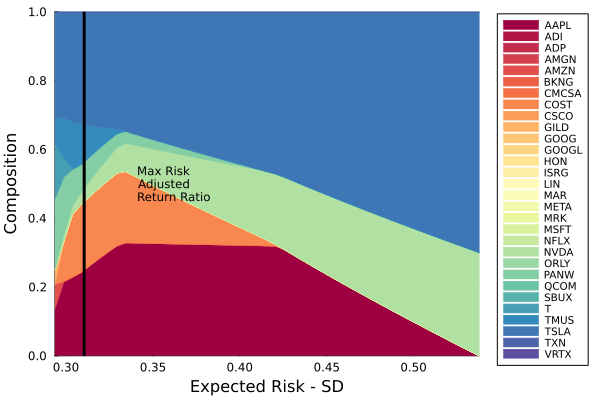

In [10]:
plot_frontier_area(port; rm = rm, kwargs_a = (; legendfontsize = 7))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*